# 2D Pose Estimation - UNet Architecture

## Based on [Keras Implementation for Biomedical Image Segmentation](https://github.com/zhixuhao/unet)

## Imports 

In [2]:
import os, sys
import numpy as np
import tensorflow as tf # Tensorflow 2
print(tf.__version__)

2.1.0


In [3]:
from tensorflow.keras.optimizers import Adam
import h5py, wandb
from wandb.keras import WandbCallback
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Relative Imports
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from lib import utils, generators, losses
from lib.models.unet_simple import unet_simple

/home/jupyter/thirdeye_test


## Parameters

In [31]:
# On low RAM, machine, Use Generator for Data Input
# For high RAM machine, Load Full Dataset into RAM
USE_GENERATOR = False

IMAGE_RESOLUTION = 256 # Image Shape (int)

HEATMAP_STD = 2 # Heatmap Keypoint Kernel Standard Deviation (in Pixels)

BATCH_SIZE = 16

NUM_SAMPLES = 160 # Max = 56636, From h5 File

NUM_VAL_SAMPLES = 32 # Max = 2366, From h5 File

EPOCHS = 1

LOSS_TYPE = 'binary_crossentropy' # Either str from Keras Builtin Losses or from utils/loss.py

METRICS = ['Accuracy']

CALLBACKS = []

REINITIALIZE = True # Reinitialize Model Weights before Training

LEARNING_RATE = 0.001
DECAY = 1e-6
OPTIMIZER = Adam(lr=LEARNING_RATE, decay=DECAY)

WANDB = False # Boolean whether or not to log in Weights and Biases
PROJECT_NAME = 'unet-2d-pose'
RUN_NAME = 'nonfunctioning_test_model'
NOTES = 'Loss Experimentation w/ sample subset'
MODEL = 'UNet'
DATA = 'COCO'

VMIN = 0.01 # Colormap Lower Cutoff for Displaying Heamaps

desired_joints = ['left_shoulder',
                  'right_shoulder',
                  'left_elbow',
                  'right_elbow',
                  #'left_wrist',
                  #'right_wrist',
                  #'left_hip',
                  #'right_hip',
                  #'left_knee',
                  #'right_knee',
                  #'left_ankle',
                  #'right_ankle'
                 ]

CMAP = plt.get_cmap('jet')
CMAP.set_under('k', alpha=0)

### Weights and Biases

In [6]:
if WANDB == True:
    wandb.init(project=PROJECT_NAME,
               notes=NOTES,
               name=RUN_NAME,
               resume=False,
               )
    wandb.config.update({
        "model": MODEL,
        "data": DATA,
        "img_resolution": IMAGE_RESOLUTION,
        "loss": str(LOSS_TYPE),
        "samples": NUM_SAMPLES,
        "val_samples": NUM_VAL_SAMPLES,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "optimizer": str(OPTIMIZER),
        "lr": str(LEARNING_RATE),
        "decay": str(DECAY),
        "keypoint_kernel_pixel_stdev": HEATMAP_STD,
        })
    wandb_callback = WandbCallback(
            save_model=False,
            monitor='loss',
            mode='auto',
            )
    CALLBACKS = [wandb_callback]
    

## Load Datasets


In [7]:
# Load h5 File
h5_train_data = h5py.File('../data/coco_train_256_x56637.h5', 'r')
h5_val_data = h5py.File('../data/coco_val_256_x2366.h5', 'r')
print(list(h5_train_data.attrs.keys()))

['jointnames']


In [8]:
# Get Key List Showing All Samples
h5_train_datalist = list(h5_train_data.keys())
print('Number of Train Samples: {}'.format(len(h5_train_datalist)))
h5_val_datalist = list(h5_val_data.keys())
print('Number of Val Samples: {}'.format(len(h5_val_datalist)))
print('--First 6 Names (Training)--')
print(h5_train_datalist[0:6])

Number of Train Samples: 56637
Number of Val Samples: 2366
--First 6 Names (Training)--
['aaab183973', 'aaab425066', 'aaag33773', 'aaan200423', 'aabc43742', 'aacb505479']


#### Sort Desired Joints from h5 Input

In [9]:
# Joints List from h5 Input
input_joints = list(h5_train_data.attrs['jointnames'])

# Create List of Original Input Indices
joint_input_indices = []
for i in input_joints:
    for d in desired_joints:
        if i == d:
            joint_input_indices.append(input_joints.index(i))

print(joint_input_indices)

[5, 6, 7, 8]


## Test Data from h5





Img Batch: (16, 256, 256, 3)
Keypoints Batch: (16, 256, 256, 4)
left_shoulder
Min Val: 0.0
Max Val: 1.0


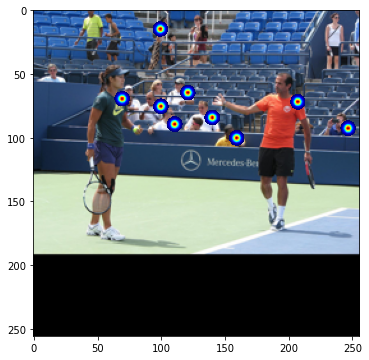

In [10]:
# Create Data Generators
training_generator = generators.h5_generator(h5_train_data, batch_size=BATCH_SIZE,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  heatmap_std=HEATMAP_STD)

val_generator = generators.h5_generator(h5_val_data, batch_size=BATCH_SIZE,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  heatmap_std=HEATMAP_STD)

# Get Sample Batch
batch_number = 0
[ batch_x, batch_y ] = training_generator.__getitem__(batch_number)
print('Img Batch: {}'.format(batch_x.shape))
print('Keypoints Batch: {}'.format(batch_y.shape))

# Test Sample Keypoints Heatmap
iteration_number = 0
plt.imshow(batch_x[iteration_number, :, :])

joint_number = 0
print(desired_joints[joint_number])
print('Min Val: {}'.format(np.amin(batch_y[iteration_number, :, :, joint_number])))
print('Max Val: {}'.format(np.amax(batch_y[iteration_number, :, :, joint_number])))
plt.imshow(batch_y[iteration_number, :, :, joint_number], cmap=CMAP, vmin=VMIN)
plt.gcf().set_size_inches(6, 6)

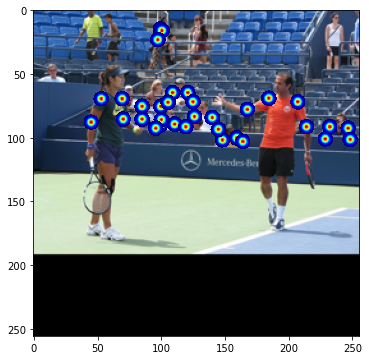

In [11]:
# Overlay all Joints on Original Image
plt.imshow(batch_x[iteration_number, :, :])

for keypoint in range(len(desired_joints)):
  # If Keypoint Exists in image
  if np.amax(batch_y[iteration_number, :, :, keypoint]) != 0:
    plt.imshow(batch_y[iteration_number, :, :, keypoint], cmap=CMAP, vmin=VMIN)
plt.gcf().set_size_inches(6, 6)

## UNet Model

In [12]:
model = unet_simple(input_shape = (IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3), \
                     output_num = len(desired_joints))

model.compile(optimizer = OPTIMIZER, loss = LOSS_TYPE, metrics = METRICS)

# Print Full Model Summary
# model.summary()

## Train Model

In [13]:
# Reinitialize Weights
if REINITIALIZE == True:
    model.compile(optimizer = OPTIMIZER, loss = LOSS_TYPE, metrics = METRICS)

# Train Model
if USE_GENERATOR == True:
    model.fit_generator(
                        generator=training_generator,
                        steps_per_epoch=int(NUM_SAMPLES/BATCH_SIZE),
                        validation_data=val_generator,
                        validation_freq=1,
                        validation_steps=int(NUM_VAL_SAMPLES/BATCH_SIZE),
                        epochs=EPOCHS,
                        callbacks=CALLBACKS
                        )

elif USE_GENERATOR == False:
    # Use Generator to Load All Data into Tensors
    training_generator = generators.h5_generator(h5_train_data, batch_size=NUM_SAMPLES,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  heatmap_std=HEATMAP_STD)
    [ img_train_tensor, keypoints_train_tensor ] = training_generator.__getitem__(0)
    
    val_generator = generators.h5_generator(h5_val_data, batch_size=NUM_VAL_SAMPLES,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  heatmap_std=HEATMAP_STD)
    [ img_val_tensor, keypoints_val_tensor ] = val_generator.__getitem__(0)
    
    # Train Model
    model.fit(x=img_train_tensor, y=keypoints_train_tensor, batch_size=BATCH_SIZE, 
              epochs=EPOCHS, callbacks=CALLBACKS,
              validation_data=[img_val_tensor, keypoints_val_tensor],
              shuffle=True,
             )



Train on 160 samples, validate on 32 samples
160/160 [==============================] - 517s 3s/sample - loss: 1.7023 - Accuracy: 0.2012 - val_loss: 0.0528 - val_Accuracy: 0.0000e+00


# Prediction

### Choose Image

32/32 [==============================] - 27s 852ms/sample
--Joint 1--
Min Val: 5.332664902512425e-15
Max Val: 0.4740890860557556
--Joint 2--
Min Val: 2.7334221691655003e-11
Max Val: 0.48650702834129333
--Joint 3--
Min Val: 1.9859100376938858e-15
Max Val: 0.4889261722564697
--Joint 4--
Min Val: 2.1611416991927933e-17
Max Val: 0.4994666278362274


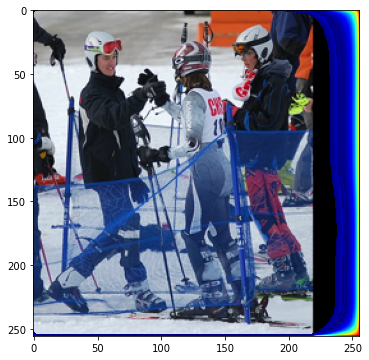

In [14]:
# Get Random Index in h5 File
pred_generator = generators.h5_generator(h5_val_data, batch_size=1,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  heatmap_std=HEATMAP_STD)
[ pred_img_tensor, pred_keypoints_tensor ] = val_generator.__getitem__(0)

# Predict Image Joints from Sample
predictions = model.predict(pred_img_tensor, verbose=1)

# Retrieve Index from Image Tensor
pred_img = pred_img_tensor[0,:]
# Get Corresponding Keypoints
pred_heatmaps = predictions[0,:]

# Overlay all Joints on Original Image
plt.imshow(pred_img)

for keypoint in range(len(desired_joints)):
    # If Keypoint Exists in image
    if np.amax(pred_heatmaps[:, :, keypoint]) != 0:
        plt.imshow(pred_heatmaps[:, :, keypoint], cmap=CMAP, vmin=VMIN)
    
plt.gcf().set_size_inches(6, 6)
    
# Print Prediction Array Stats
for joint in range(len(desired_joints)):
    print('--Joint {}--'.format(joint+1))
    print('Min Val: {}'.format(np.amin(predictions[0, :, :, joint])))
    print('Max Val: {}'.format(np.amax(predictions[0, :, :, joint])))

if WANDB == True:
    wandb.log({"True Heatmap": plt})

left_shoulder


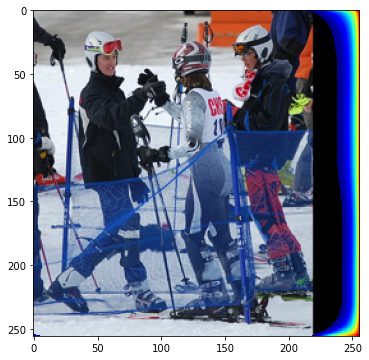

In [15]:
# Choose Joint
joint = 0
print(desired_joints[joint])

plt.imshow(pred_img)

# HeatMap
if np.amax(pred_heatmaps[:, :, keypoint]) != 0:
    plt.imshow(predictions[0, :, :, joint], cmap=CMAP, vmin=VMIN,)
else:
    print('Heatmap Plot Error: Max Value in Prediction is {}'.format(np.amax(predictions[0, :, :, joint])))
    print('Heatmap Error: in Prediction is {}'.format(np.amin(predictions[0, :, :, joint])))
plt.gcf().set_size_inches(6, 6)

# Save Model

In [34]:
# Export TF SavedModel
tf.keras.models.save_model(
    model, ('../SavedModels/' + PROJECT_NAME + '/' + RUN_NAME), overwrite=True, include_optimizer=True,
    signatures=None, options=None
)

INFO:tensorflow:Assets written to: ../SavedModels/unet-2d-pose/nonfunctioning_test_model/assets


In [37]:
# Copy SavedModel to GCS in Terminal (Ingored from Git)